# NBA OUTLIER DETECTION USING ROBUST COVARIANCE ESTIMATION

## 1. Introduction

In this note book we aim to perform outlier detection on the NBA player data for the years 2000 to 2004 using an ROBUST COVARIANCE ESTIMATION algorithm, which draws and elliptic envelope around the most dense data points to locate outliers. The goal is to find outstanding players and we shall compare the players found to the actual MVPs of those seasons as well as notice the trend in outstanding players over those years.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope

## 2. Data Aquisition

We make use of the data from the basketballreference.com, we only use the player data sets since we are only interested in detecting outstanding players.

In [90]:
player_allstar_df = pd.read_csv('databasebasketball/player_allstar.txt', sep=",")
player_playoffs_career_df = pd.read_csv('databasebasketball/player_playoffs_career.txt', sep=",")
player_playoffs_df = pd.read_csv('databasebasketball/player_playoffs.txt', sep=",")
player_regular_season_career_df = pd.read_csv('databasebasketball/player_regular_season_career.txt', sep=",")
player_regular_season_df = pd.read_csv('databasebasketball/player_regular_season.txt', sep=",")
players_df = pd.read_csv('databasebasketball/players.txt', sep=",")

## 3. Data-Preprocessing

In [91]:
def clean_duplicates(df):
    
    """
    
    This function removes duplicates from the dataframe of interest. Since players are sometimes drafted during 
    a season and we would like to remove the deupliacted information.
    
    
    """
    
    
    
    flagged_duplicates = df.duplicated(subset=['ilkid','year'], keep=False)
    
    to_drop = [] 
    
    for i in range(flagged_duplicates.shape[0]):
        if(flagged_duplicates[i]==True and df.iloc[i]['team'] != "TOT"):
            to_drop.append(i)
    
    for i in range(len(to_drop)):
        df.drop(to_drop[i],inplace=True)
    
    return df

Now we can define our data after we clear out the duplicates from the player_regular_season dataframe. We then visualize the last 10 items in the dataframe

In [92]:
data = clean_duplicates(player_regular_season_df)

In [93]:
data.tail(10)

,ilkid,year,firstname,lastname,team,leag,gp,minutes,pts,oreb,...,stl,blk,turnover,pf,fga,fgm,fta,ftm,tpa,tpm
19102,WILLIFR02,2004,Frank,Williams,CHI,N,9,71,6,2,...,2,3,3.0,9,20,3,0,0,4,0
19103,WILLIJA02,2004,Jason,Williams,MEM,N,71,1952,719,19,...,75,5,130.0,91,644,266,101,80,330,107
19104,WILLIJE01,2004,Jerome,Williams,NYK,N,79,1211,359,115,...,55,10,65.0,155,243,122,172,115,5,0
19105,WILLIKE01,2004,Kevin,Willis,ATL,N,29,344,87,29,...,8,7,15.0,53,90,35,23,17,2,0
19106,WILLIMA01,2004,Maurice,Williams,MIL,N,80,2254,814,50,...,74,11,196.0,221,737,323,160,136,99,32
19107,WILLISC01,2004,Scott,Williams,CLE,N,19,152,33,15,...,4,6,5.0,30,41,12,11,9,1,0
19108,WOODSLO01,2004,Loren,Woods,TOR,N,45,712,176,81,...,8,39,37.0,78,164,71,59,34,1,0
19109,WOODSQY01,2004,Qyntel,Woods,MIA,N,3,40,10,2,...,4,0,2.0,6,12,5,0,0,0,0
19110,WRIGHDO01,2004,Dorell,Wright,MIA,N,3,27,7,0,...,4,0,3.0,2,11,3,1,1,4,0
19111,WRIGHLO02,2004,Lorenzen,Wright,MEM,N,80,2287,771,177,...,58,69,100.0,251,683,320,198,131,3,0


we now need to compute the two values we shall use to perform the outlier detection they are: effciency and the appoximate value. We compute these two values and append them as columns to our dataframe called data.

The efficiency is defined as:

$\mathrm{Efficiency}=\frac{\mathrm{CREDITS}}{\mathrm{GP}}$

where $\mathrm{CREDITS}=\mathrm{PTS+REB+ASTS+STL+BLK-(FGA-FGM)-(FTA-FTM)-TO}$

the approximate value is then computed as:

$\mathrm{Approximate Value}=\frac{\mathrm{CREDITS}^{\frac{3}{4}}}{21}$

In [94]:
data['credits'] = data['pts']+data['reb']+data['asts']+data['stl']+data['blk']-(data['fga']-data['fgm'])-(data['fta']-data['ftm'])-data['turnover']

In [95]:
data['av'] = (data['credits']**(3/4))/21

In [96]:
data['eff'] = data['credits']/data['gp']

We now have the function data_4_year which extracts the subset of data from our dataframe per year. The funtion select_features will get the features to be used for outlier detection from the dataframe and returns it as a numpy array. 

In [97]:
def data_4_year(year):
    data_year = data[data['year']==year]
    data_year.reset_index(inplace=True)
    return data_year

In [98]:
def select_features(data_year):
    X = data_year[['av','eff']].to_numpy()
    X = np.nan_to_num(X)
    return X

## 4. Outlier Detection  

The goal will be to perform outlier detection using the elliptical envelope from robust covariance estimatio for the years 2000 to 2004. 

### For the year 2000

We use our functions to get the data and features for the year 2000.

In [99]:
data_for_year = data_4_year(2000)
X = select_features(data_for_year)

We first visualize the data before finding the outliers.

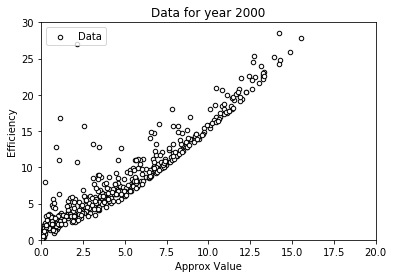

In [100]:
plt.title("Data for year 2000")


b1 = plt.scatter(X[:, 0], X[:, 1], c='white',
                 s=20, edgecolor='k')

plt.axis('tight')
plt.xlim((0, 20))
plt.ylim((0, 30))
plt.legend([b1],
          ["Data"],loc="upper left")
plt.xlabel('Approx Value')
plt.ylabel('Efficiency')
plt.show()

Now we use the built in functions from sklearn to perform outlier detection using the isolation forest method.

In [101]:
cov = EllipticEnvelope(random_state=0,contamination=0.07).fit(X)

y_pred=cov.predict(X)


In [102]:
outlier_pred=[]
for i in range(len(X)):
    if (y_pred[i] == -1):
        outlier_pred.append(X[i])
        
outlier_pred=np.array(outlier_pred)

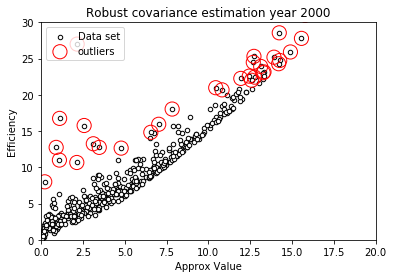

In [103]:
plt.title("Robust covariance estimation year 2000")
#plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X[:, 0], X[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(outlier_pred[:, 0], outlier_pred[:, 1], c='',
                 s=20*10, edgecolor='red',facecolor='none')

plt.axis('tight')
plt.xlim((0, 20))
plt.ylim((0, 30))
plt.legend([b1, b2],
          ["Data set",
             "outliers"],
           loc="upper left")
plt.xlabel('Approx Value')
plt.ylabel('Efficiency')
plt.show()

In the above plot we note that the outliers are circled in red. A description of the method of the robust covariance estimation is explained in the report. 

In [104]:
outlier_index1=[]

for i in outlier_pred.tolist():
    outlier_index1.append(X.tolist().index(i))
    
for i in range(len(outlier_index1)):
    print(data_for_year.iloc[outlier_index1[i]]['firstname'],data_for_year.iloc[outlier_index1[i]]['lastname'])

Elton Brand
Kobe Bryant
Marcus Camby
Vince Carter
Tim Duncan
Jamie Feick
Derek Fisher
Danny Fortson
Kevin Garnett
Anfernee Hardaway
Grant Hill
Zydrunas Ilgauskas
Allen Iverson
Marc Jackson
Jason Kidd
Karl Malone
Stephon Marbury
Shawn Marion
Antonio Mcdyess
Tracy Mcgrady
Chris Mills
Alonzo Mourning
Dirk Nowitzki
Shaquille O'neal
Gary Payton
Theo Ratliff
Mitch Richmond
Keith Vanhorn
Rasheed Wallace
Chris Webber
David Wingate


The Above are the list of names of the outstanding players for the year 2000.

### For the year 2001

In [105]:
data_for_year = data_4_year(2001)
X = select_features(data_for_year)

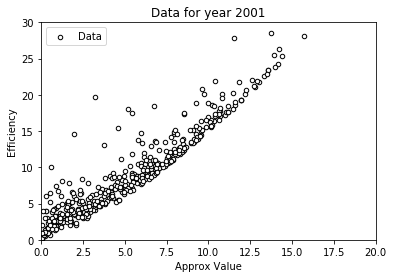

In [106]:
plt.title("Data for year 2001")


b1 = plt.scatter(X[:, 0], X[:, 1], c='white',
                 s=20, edgecolor='k')

plt.axis('tight')
plt.xlim((0, 20))
plt.ylim((0, 30))
plt.legend([b1],
          ["Data"],loc="upper left")
plt.xlabel('Approx Value')
plt.ylabel('Efficiency')
plt.show()

In [107]:
cov = EllipticEnvelope(random_state=0,contamination=0.07).fit(X)

y_pred=cov.predict(X)



In [108]:
outlier_pred=[]
for i in range(len(X)):
    if (y_pred[i] == -1):
        outlier_pred.append(X[i])
        
outlier_pred=np.array(outlier_pred)

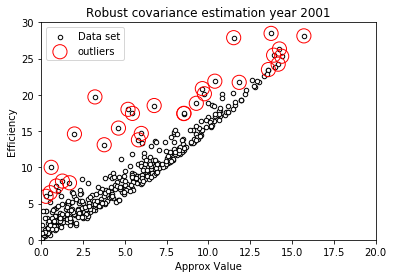

In [109]:
plt.title("Robust covariance estimation year 2001")
#plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X[:, 0], X[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(outlier_pred[:, 0], outlier_pred[:, 1], c='',
                 s=20*10, edgecolor='red',facecolor='none')

plt.axis('tight')
plt.xlim((0, 20))
plt.ylim((0, 30))
plt.legend([b1, b2],
          ["Data set",
             "outliers"],
           loc="upper left")
plt.xlabel('Approx Value')
plt.ylabel('Efficiency')
plt.show()

In [110]:
outlier_index1=[]

for i in outlier_pred.tolist():
    outlier_index1.append(X.tolist().index(i))
    
for i in range(len(outlier_index1)):
    print(data_for_year.iloc[outlier_index1[i]]['firstname'],data_for_year.iloc[outlier_index1[i]]['lastname'])

Calvin Booth
Elton Brand
Terrell Brandon
Kobe Bryant
Marcus Camby
Vince Carter
Derrick Coleman
Chris Crawford
Michael Dickerson
Tim Duncan
Steve Francis
Kevin Garnett
Al Harrington
Grant Hill
Tyrone Hill
Allen Iverson
Michael Jordan
Donyell Marshall
Jamal Mashburn
Antonio Mcdyess
Tracy Mcgrady
Dirk Nowitzki
Lamar Odom
Jermaine O'neal
Shaquille O'neal
Gary Payton
Elliot Perry
Theo Ratliff
Isaiah Rider
Chris Webber
Lorenzen Wright


### For year 2002

In [111]:
data_for_year = data_4_year(2002)
X = select_features(data_for_year)

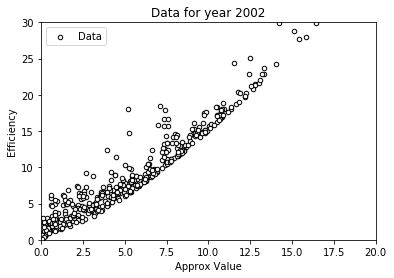

In [112]:
plt.title("Data for year 2002")


b1 = plt.scatter(X[:, 0], X[:, 1], c='white',
                 s=20, edgecolor='k')

plt.axis('tight')
plt.xlim((0, 20))
plt.ylim((0, 30))
plt.legend([b1],
          ["Data"],loc="upper left")
plt.xlabel('Approx Value')
plt.ylabel('Efficiency')
plt.show()

In [113]:
cov = EllipticEnvelope(random_state=0,contamination=0.07).fit(X)

y_pred=cov.predict(X)

In [114]:
outlier_pred=[]
for i in range(len(X)):
    if (y_pred[i] == -1):
        outlier_pred.append(X[i])
        
outlier_pred=np.array(outlier_pred)

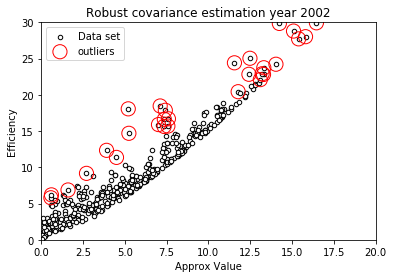

In [115]:
plt.title("Robust covariance estimation year 2002")
#plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X[:, 0], X[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(outlier_pred[:, 0], outlier_pred[:, 1], c='',
                 s=20*10, edgecolor='red',facecolor='none')

plt.axis('tight')
plt.xlim((0, 20))
plt.ylim((0, 30))
plt.legend([b1, b2],
          ["Data set",
             "outliers"],
           loc="upper left")
plt.xlabel('Approx Value')
plt.ylabel('Efficiency')
plt.show()

In [116]:
outlier_index1=[]

for i in outlier_pred.tolist():
    outlier_index1.append(X.tolist().index(i))
    
for i in range(len(outlier_index1)):
    print(data_for_year.iloc[outlier_index1[i]]['firstname'],data_for_year.iloc[outlier_index1[i]]['lastname'])

Ray Allen
Mike Bibby
Elton Brand
Kobe Bryant
Marcus Camby
Vince Carter
Chris Crawford
Antonio Davis
Baron Davis
Tim Duncan
Marcus Fizer
Kevin Garnett
Horace Grant
Grant Hill
Eddie Jones
Jason Kidd
Karl Malone
Shawn Marion
Tracy McGrady
Dikembe Mutombo
Dirk Nowitzki
Lamar Odom
Michael Olowokandi
Jermaine O'Neal
Shaquille O'Neal
Paul Pierce
Wally Szczerbiak
Ben Wallace
Chris Webber
Jahidi White


### For year 2003

In [117]:
data_for_year = data_4_year(2003)
X = select_features(data_for_year)

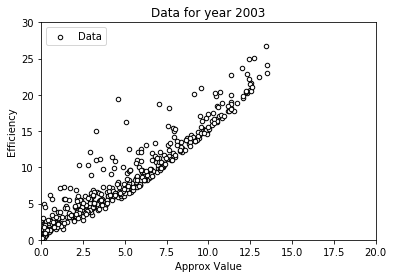

In [118]:
plt.title("Data for year 2003")


b1 = plt.scatter(X[:, 0], X[:, 1], c='white',
                 s=20, edgecolor='k')

plt.axis('tight')
plt.xlim((0, 20))
plt.ylim((0, 30))
plt.legend([b1],
          ["Data"],loc="upper left")
plt.xlabel('Approx Value')
plt.ylabel('Efficiency')
plt.show()

In [119]:
cov = EllipticEnvelope(random_state=0,contamination=0.07).fit(X)

y_pred=cov.predict(X)

In [120]:
outlier_pred=[]
for i in range(len(X)):
    if (y_pred[i] == -1):
        outlier_pred.append(X[i])
        
outlier_pred=np.array(outlier_pred)

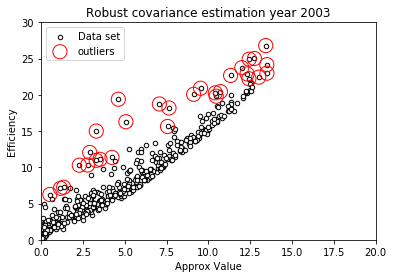

In [121]:
plt.title("Robust covariance estimation year 2003")
#plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X[:, 0], X[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(outlier_pred[:, 0], outlier_pred[:, 1], c='',
                 s=20*10, edgecolor='red',facecolor='none')

plt.axis('tight')
plt.xlim((0, 20))
plt.ylim((0, 30))
plt.legend([b1, b2],
          ["Data set",
             "outliers"],
           loc="upper left")
plt.xlabel('Approx Value')
plt.ylabel('Efficiency')
plt.show()

In [122]:
outlier_index1=[]

for i in outlier_pred.tolist():
    outlier_index1.append(X.tolist().index(i))
    
for i in range(len(outlier_index1)):
    print(data_for_year.iloc[outlier_index1[i]]['firstname'],data_for_year.iloc[outlier_index1[i]]['lastname'])

Ray Allen
Gilbert Arenas
Carlos Boozer
Elton Brand
Kobe Bryant
Tyson Chandler
Mateen Cleaves
Jason Collier
Baron Davis
Tim Duncan
Kevin Garnett
Matt Harpring
Allen Iverson
Marc Jackson
Jason Kidd
Raef LaFrentz
Karl Malone
Shawn Marion
Kenyon Martin
Jamal Mashburn
Tracy McGrady
Brad Miller
Alonzo Mourning
Troy Murphy
Dirk Nowitzki
Shaquille O'Neal
Jamal Sampson
Jerry Stackhouse
Predrag Stojakovic
Amare Stoudemire
Chris Webber


### For year 2004

In [123]:
data_for_year = data_4_year(2004)
X = select_features(data_for_year)

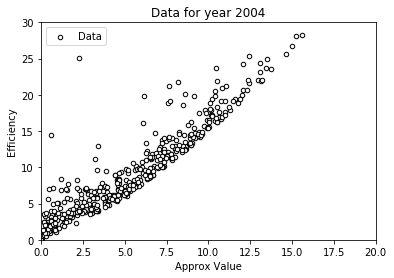

In [124]:
plt.title("Data for year 2004")


b1 = plt.scatter(X[:, 0], X[:, 1], c='white',
                 s=20, edgecolor='k')

plt.axis('tight')
plt.xlim((0, 20))
plt.ylim((0, 30))
plt.legend([b1],
          ["Data"],loc="upper left")
plt.xlabel('Approx Value')
plt.ylabel('Efficiency')
plt.show()

In [125]:
cov = EllipticEnvelope(random_state=0,contamination=0.07).fit(X)

y_pred=cov.predict(X)

In [126]:
outlier_pred=[]
for i in range(len(X)):
    if (y_pred[i] == -1):
        outlier_pred.append(X[i])
        
outlier_pred=np.array(outlier_pred)

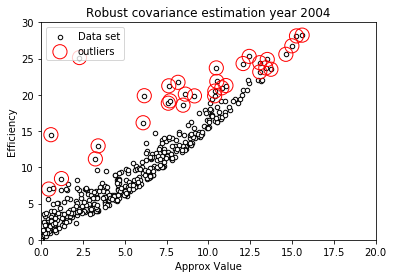

In [127]:
plt.title("Robust covariance estimation year 2004")
#plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X[:, 0], X[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(outlier_pred[:, 0], outlier_pred[:, 1], c='',
                 s=20*10, edgecolor='red',facecolor='none')

plt.axis('tight')
plt.xlim((0, 20))
plt.ylim((0, 30))
plt.legend([b1, b2],
          ["Data set",
             "outliers"],
           loc="upper left")
plt.xlabel('Approx Value')
plt.ylabel('Efficiency')
plt.show()

In [128]:
outlier_index1=[]

for i in outlier_pred.tolist():
    outlier_index1.append(X.tolist().index(i))
    
for i in range(len(outlier_index1)):
    print(data_for_year.iloc[outlier_index1[i]]['firstname'],data_for_year.iloc[outlier_index1[i]]['lastname'])

Shareef Abdur-Rahim
Ron Artest
Carlos Boozer
Elton Brand
Kobe Bryant
Baron Davis
Tim Duncan
Ndudi Ebi
Kevin Garnett
Pau Gasol
Larry Hughes
Allen Iverson
Bobby Jackson
LeBron James
Richard Jefferson
Jason Kidd
Andrei Kirilenko
Voshon Lenard
Corey Maggette
Jamaal Magloire
Shawn Marion
Tracy McGrady
Brad Miller
Dirk Nowitzki
Lamar Odom
Jermaine O'Neal
Shaquille O'Neal
Zach Randolph
Glenn Robinson
Amare Stoudemire
Jamaal Tinsley
Dwyane Wade
Chris Webber
